In [7]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import shutil
import matplotlib.pyplot as plt
import sys
from collections import Counter
import re
sys.path.append('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/')
import model_training_utils
#from crop_data_utils import parse_image_filename

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create local enviroment dataset, transfrom data into concatenated arrays and export
## (1-time operation)
#### this is done for **colab notebooks** and data stored on **gdrive**, this step helps speeding up the training part significantly

In [2]:
train_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/train/'
valid_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid/'
test_folder = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/test/'

train_folder_gdrive = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/train/'
train_folder_gdrive_0 = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/train/0'
train_folder_gdrive_1 = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/train/1'

valid_folder_grive = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid'
valid_folder_gdrive_0 = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid/0'
valid_folder_gdrive_1 = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/valid/1'

test_folder_gdrive = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/test'
test_folder_gdrive_0 = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/test/0'
test_folder_gdrive_1 = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/dataset/val/test/1'

In [3]:
# check dataset
model_training_utils.count_files_in_folders(train_folder_gdrive_0,train_folder_gdrive_1,
                                            valid_folder_gdrive_0,valid_folder_gdrive_1,
                                            test_folder_gdrive_0,test_folder_gdrive_1)

Total files in Folder Pair 1: 16971
Files in Folder 0 of Pair 1: 12257, Files in Folder 1 of Pair 1: 4714

Total files in Folder Pair 2: 2125
Files in Folder 0 of Pair 2: 1512, Files in Folder 1 of Pair 2: 613

Total files in Folder Pair 3: 2126
Files in Folder 0 of Pair 3: 1519, Files in Folder 1 of Pair 3: 607

Total files in all Folder Pairs: 21222


In [4]:
# copy folders from external source to local environment
train_folder_0 = '/content/dataset/train/0'
train_folder_1 = '/content/dataset/train/1'

valid_folder = '/content/dataset/valid'
valid_folder_0 = '/content/dataset/valid/0'
valid_folder_1 = '/content/dataset/valid/1'

test_folder = '/content/dataset/test'
test_folder_0 = '/content/dataset/test/0'
test_folder_1 = '/content/dataset/test/1'

try:
    shutil.copytree(train_folder_gdrive_0,train_folder_0)
    shutil.copytree(train_folder_gdrive_1,train_folder_1)
    shutil.copytree(valid_folder_grive,valid_folder)
    shutil.copytree(test_folder_gdrive,test_folder)
    print("Local Folders created")
except Exception as ex:
    print(f"{ex}")

Local Folders created


### additional checks

In [5]:
model_training_utils.count_files_in_folders(train_folder_0,train_folder_1,
                                            valid_folder_0,valid_folder_1,
                                            test_folder_0,test_folder_1)

Total files in Folder Pair 1: 16971
Files in Folder 0 of Pair 1: 12257, Files in Folder 1 of Pair 1: 4714

Total files in Folder Pair 2: 2125
Files in Folder 0 of Pair 2: 1512, Files in Folder 1 of Pair 2: 613

Total files in Folder Pair 3: 2126
Files in Folder 0 of Pair 3: 1519, Files in Folder 1 of Pair 3: 607

Total files in all Folder Pairs: 21222


In [ ]:
# @title
def img_printer(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        plt.imshow(img)
        plt.axis('off')
        print(img.shape)
        plt.show()
    else:
        print(f"Failed to read image from '{img_path}'")

In [6]:
img_path = os.path.join(train_folder_gdrive_1,'10005_1000005_t2w9_t2w_class1.png')
model_training_utils.img_printer(img_path)

AttributeError: ignored

## Preprocessing

In [ ]:
# @title
import re
def parse_image_filename(filename):
    #filename = filepath.split('/')[-1]
    parts = filename.split('_')
    patient_id = '_'.join(parts[:2])
    study_id = parts[1]
    image_type = parts[3]
    class_label = int(re.search(r'class(\d+)', parts[-1]).group(1))
    slice_index = int(re.search(rf'{image_type}(\d+)', filename).group(1))
    return patient_id, image_type, class_label, slice_index

# Example usage
filepath = '/content/drive/MyDrive/ABELE_prostate/claudio/CSV/dataset/prostate_centered/80x80_stk/rgb/train/0/11100_1001000_adc17_adc_class1.png'
filename = '10000_1000000_adc12_adc_class0.png'
patient_id, image_type, class_label, slice_index = parse_image_filename(filename)
print("Patient ID:", patient_id)
print("Study ID:", study_id)
print("Image Type:", image_type)
print("Class Label:", class_label)
print("Slice Index:", slice_index)

In [21]:
# @title
def preprocessing(image):
    image = np.uint16(image * 255.0)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4,4))
    image = clahe.apply(image) + 30

    return image

Image shape: (64, 64)


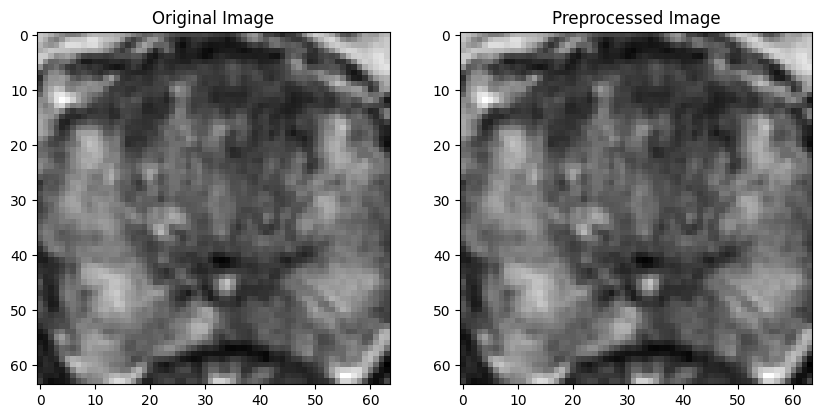

In [ ]:
img_path = '/content/dataset/test/0/10020_1000020_t2w10_t2w_class0.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_preprocessed = preprocessing(img)
if img is not None:
    print("Image shape:", img.shape)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(img_preprocessed, cmap='gray')
    axs[1].set_title('Preprocessed Image')
    plt.show()
else:
    print("Failed to load image.")

In [15]:
def parse_image_filename(filename, class_label=True):
    if class_label:
        parts = filename.split('_')
        patient_id = '_'.join(parts[:2])
        study_id = parts[1]
        image_type = parts[3]
        class_label = int(re.search(r'class(\d+)', parts[-1]).group(1))
        slice_index = int(re.search(rf'{image_type}(\d+)', filename).group(1))
        return patient_id, study_id, image_type, class_label, slice_index
    else:
        filename = filename.split('.')[0]
        parts = filename.split('_')
        patient_id = '_'.join(parts[:2])
        study_id = parts[1]
        image_type = parts[-1]
        slice_index = int(parts[2][3:])
        return patient_id, study_id, image_type, slice_index

In [19]:
def array_stacking(folder_path, subset=''):
    image_pairs = {}
    stacked_arrays = []
    labels = []
    for root, dirs, files in os.walk(folder_path):
        for img_path in files:
            img_name = os.path.basename(img_path)
            patient_id, study_id, image_type, label, slice_index = parse_image_filename(img_name, class_label=True)
            key = (patient_id, slice_index)
            image_pairs.setdefault(key, {})[image_type] = os.path.join(root, img_path)
            image_pairs[key]['label'] = label
    # Pair and stack images
    for key, image_data in image_pairs.items():
        patient_id, slice_index = key
        if 't2w' in image_data and 'adc' in image_data and 'hbv' in image_data:
            t2w_path = image_data['t2w']
            adc_path = image_data['adc']
            hbv_path = image_data['hbv']
            label = image_data['label']
            # Load and preprocess the images as grayscale
            t2w_image = cv2.imread(t2w_path, cv2.IMREAD_GRAYSCALE)
            adc_image = cv2.imread(adc_path, cv2.IMREAD_GRAYSCALE)
            hbv_image = cv2.imread(hbv_path, cv2.IMREAD_GRAYSCALE)
            t2w_image = preprocessing(t2w_image)
            adc_image = preprocessing(adc_image)
            hbv_image = preprocessing(hbv_image)
            # possibility to apply data augmentation on training images
            if subset == 'train':
                t2w_array = np.array(t2w_image)
                adc_array = np.array(adc_image)
                hbv_array = np.array(hbv_image)
                t2w_array = np.expand_dims(t2w_image, axis=-1)
                adc_array = np.expand_dims(adc_image, axis=-1)
                hbv_array = np.expand_dims(hbv_image, axis=-1)
                stacked_arrays.append(np.concatenate([t2w_array, adc_array,hbv_array], axis=-1))
                labels.append(label)
            else:
                t2w_array = np.array(t2w_image)
                adc_array = np.array(adc_image)
                hbv_array = np.array(hbv_image)
                t2w_array = np.expand_dims(t2w_image, axis=-1)
                adc_array = np.expand_dims(adc_image, axis=-1)
                hbv_array = np.expand_dims(hbv_image, axis=-1)
                stacked_arrays.append(np.concatenate([t2w_array, adc_array,hbv_array], axis=-1))
                labels.append(label)
    return np.array(stacked_arrays), np.array(labels)

In [22]:
# Load and stack images for train, valid, and test sets
X_train, y_train = array_stacking(train_folder, subset='train')
X_valid, y_valid = array_stacking(valid_folder, subset='valid')
X_test, y_test = array_stacking(test_folder, subset='test')
# Count the occurrences of each label
label_counts_train = Counter(y_train)
label_counts_valid = Counter(y_valid)
label_counts_test = Counter(y_test)

print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)
# Print the label distribution for train set
print("\nTrain set:")
for label, count in label_counts_train.items():
    print(f"Label {label}: {count} samples")
# Print the label distribution for validation set
print("\nValidation set:")
for label, count in label_counts_valid.items():
    print(f"Label {label}: {count} samples")
# Print the label distribution for test set
print("\nTest set:")
for label, count in label_counts_test.items():
    print(f"Label {label}: {count} samples")

Shape of X_train: (5597, 64, 64, 3)
Shape of X_valid: (700, 64, 64, 3)
Shape of X_test: (703, 64, 64, 3)

Train set:
Label 0: 4045 samples
Label 1: 1552 samples

Validation set:
Label 0: 497 samples
Label 1: 203 samples

Test set:
Label 0: 502 samples
Label 1: 201 samples


## Save np.arrays externally

In [1]:
# Define file paths for saving
train_data_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_train.npy'
train_labels_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/y_train.npy'
valid_data_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_valid.npy'
valid_labels_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/y_valid.npy'
test_data_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_test.npy'
test_labels_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/y_test.npy'
os.makedirs('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/', exist_ok=True)

# Save the arrays to local files
np.save(train_data_file, X_train)
np.save(train_labels_file, y_train)
np.save(valid_data_file, X_valid)
np.save(valid_labels_file, y_valid)
np.save(test_data_file, X_test)
np.save(test_labels_file, y_test)
print("Arrays saved successfully.")

NameError: ignored

# Model Building

In [4]:
train_data_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_train.npy'
train_labels_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/y_train.npy'
valid_data_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_valid.npy'
valid_labels_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/y_valid.npy'
test_data_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/X_test.npy'
test_labels_file = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/np_array/val/y_test.npy'
# Load the arrays from the saved files
X_train = np.load(train_data_file)
y_train = np.load(train_labels_file)
X_valid = np.load(valid_data_file)
y_valid = np.load(valid_labels_file)
X_test = np.load(test_data_file)
y_test = np.load(test_labels_file)
# standardize labels
y_train = np.reshape(y_train, (-1, 1))
y_valid = np.reshape(y_valid, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [8]:
# Count the occurrences of each label
label_counts_train = Counter(y_train)
label_counts_valid = Counter(y_valid)
label_counts_test = Counter(y_test)

print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of X_test:", X_test.shape)

# Print the label distribution for train set
print("\nTrain set:")
for label, count in label_counts_train.items():
    print(f"Label {label}: {count} samples")

# Print the label distribution for validation set
print("\nValidation set:")
for label, count in label_counts_valid.items():
    print(f"Label {label}: {count} samples")

# Print the label distribution for test set
print("\nTest set:")
for label, count in label_counts_test.items():
    print(f"Label {label}: {count} samples")

TypeError: ignored

In [27]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(buffer_size=len(X_train)).batch(batch_size=128)

valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_data = valid_data.batch(batch_size=1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(batch_size=1)

train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint16, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [14]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras.models import Model

def resnet(input_shape=(64, 64, 3), num_classes=1):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the weights of the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = True

    # custom classification layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=outputs)

    #alpha = 1e-5
    #for layer in model.layers:
        #if hasattr(layer, "kernel_regularizer"):
            #layer.kernel_regularizer = tf.keras.regularizers.l2(alpha)

    return model

In [6]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from keras.regularizers import l2
from keras.models import Model

def residual_block(x, filters, stride=1, first_block=False):
    weight_decay=1e-4

    # Shortcut connection
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    # Adjusting dimensions of the shortcut to match the main path
    if first_block:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def resnet_v2_20(input_shape=(64, 64, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    weight_decay=1e-4

    # Initial convolution layer
    x = Conv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stacking residual blocks
    num_blocks = [3, 3, 3]
    filters = [16, 32, 64]

    for stage in range(3):
        for block in range(num_blocks[stage]):
            stride = 1
            if stage > 0 and block == 0:
                stride = 2

            x = residual_block(x, filters[stage], stride=stride, first_block=(block == 0))

    # Global average pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, x, name='resnet_v2_20')
    return model

In [7]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU
from keras.models import Model

def cnn(input_shape=(64, 64, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

In [8]:
# @title
# Custom Weighted Binary Cross-Entropy Loss function
from keras import backend as K
from keras.backend import clip, log, mean

def wbce(weight1, weight0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        y_true = K.clip(y_true, K.epsilon(), 1 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        logloss = -(y_true * K.log(y_pred) * weight1 + (1 - y_true) * K.log(1 - y_pred) * weight0)
        return K.mean(logloss, axis=-1)
    return loss

In [9]:
# @title

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch % 50 == 0:
        lr *= 0.1
        return lr
    else:
        return lr

In [13]:
def scheduler(epoch, lr):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 120:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [19]:
from keras.optimizers import Adam, SGD
from keras.losses import binary_crossentropy

num_classes = 1
model = resnet()
optimizer = SGD(learning_rate=1e-5, momentum = 0.9)
loss = model_training_utils.wbce(7,3)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', 'AUC'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

## Model Fitting

In [17]:
# Define callbacks
from keras.callbacks import LearningRateScheduler

checkpoint_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/models/best_model_auc.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_best_only=True,
                                                monitor='val_auc',
                                                mode='max')
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(model_training_utils.scheduler)

In [20]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    callbacks=[lr_scheduler,checkpoint],
                    epochs=200)

test_loss, test_accuracy, auc = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", auc)

Epoch 1/200
44/44 [==============================] - 74s 364ms/step - loss: 4.3477 - accuracy: 0.3802 - auc: 0.4972 - val_loss: 4.2264 - val_accuracy: 0.3257 - val_auc: 0.5043 - lr: 1.0000e-05
Epoch 2/200
44/44 [==============================] - 14s 333ms/step - loss: 3.8030 - accuracy: 0.4524 - auc: 0.5304 - val_loss: 3.3943 - val_accuracy: 0.4457 - val_auc: 0.4895 - lr: 1.0000e-05
Epoch 3/200
44/44 [==============================] - 16s 374ms/step - loss: 3.5625 - accuracy: 0.4863 - auc: 0.5362 - val_loss: 3.1492 - val_accuracy: 0.5143 - val_auc: 0.5122 - lr: 1.0000e-05
Epoch 4/200
44/44 [==============================] - 16s 372ms/step - loss: 3.4240 - accuracy: 0.5228 - auc: 0.5522 - val_loss: 3.0542 - val_accuracy: 0.5529 - val_auc: 0.5410 - lr: 1.0000e-05
Epoch 5/200
44/44 [==============================] - 14s 324ms/step - loss: 3.2606 - accuracy: 0.5460 - auc: 0.5773 - val_loss: 2.9347 - val_accuracy: 0.5929 - val_auc: 0.5862 - lr: 1.0000e-05
Epoch 6/200
44/44 [================

# Model Evaluation

In [2]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/models/best_model_auc.h5'
model = load_model(model_path, compile=False)

In [31]:
from sklearn.metrics import classification_report
import numpy as np

data_list = [(valid_data, y_valid), (test_data, y_test)]
for data in data_list:
    # Predict on the dataset using the model
    predictions = model.predict(data[0])
    predicted_labels = np.round(predictions).astype(int)
    # Generate the classification report
    report = classification_report(data[1],
                                    predicted_labels,
                                    target_names=['Class 0', 'Class 1'])
    if data == data_list[0]:
        print('\nValidation\n', report)
    else:
        print('\nTest\n', report)

700/700 [==============================] - 8s 11ms/step
Validation
               precision    recall  f1-score   support

     Class 0       0.82      0.64      0.72       497
     Class 1       0.42      0.66      0.51       203

    accuracy                           0.64       700
   macro avg       0.62      0.65      0.62       700
weighted avg       0.70      0.64      0.66       700

703/703 [==============================] - 6s 9ms/step
Test
               precision    recall  f1-score   support

     Class 0       0.83      0.56      0.67       502
     Class 1       0.40      0.71      0.51       201

    accuracy                           0.61       703
   macro avg       0.61      0.64      0.59       703
weighted avg       0.71      0.61      0.62       703



700/700 [==============================] - 5s 7ms/step


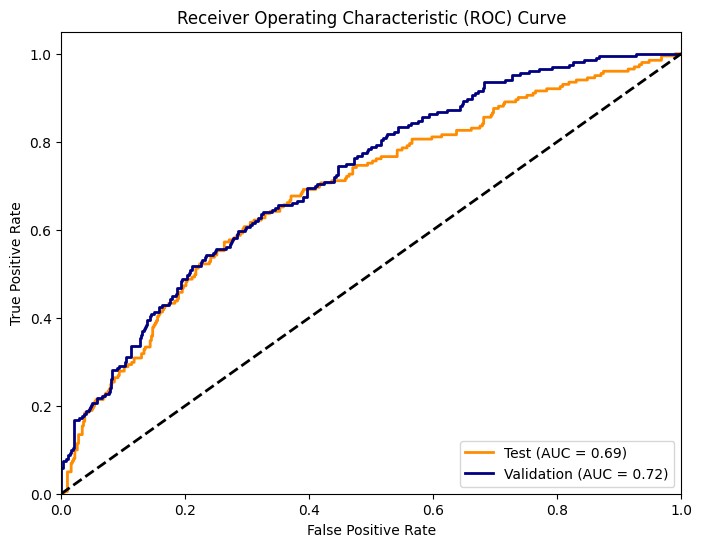

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test and validation sets
predicted_probs_te = model.predict(test_data)
predicted_probs_val = model.predict(valid_data)

# Calculate ROC curve and AUC for test set
fpr_te, tpr_te, thresholds_te = roc_curve(y_test, predicted_probs_te)
roc_auc_te = auc(fpr_te, tpr_te)

# Calculate ROC curve and AUC for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_valid, predicted_probs_val)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curve for both test and validation sets
plt.figure(figsize=(8, 6))

plt.plot(fpr_te, tpr_te, color='darkorange', lw=2, label=f'Test (AUC = {roc_auc_te:.2f})')
plt.plot(fpr_val, tpr_val, color='navy', lw=2, label=f'Validation (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

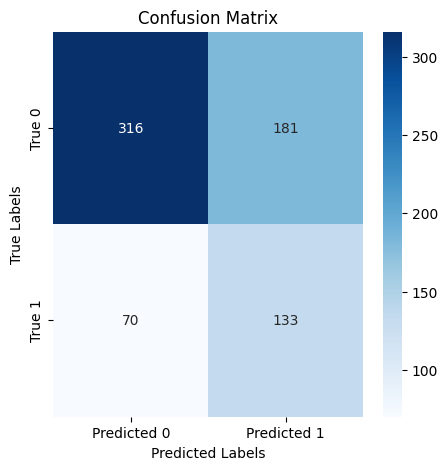

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
predicted_labels = (predicted_probs > 0.5).astype(int)  # Assuming binary classification with a threshold of 0.5

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_valid, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

NameError: ignored

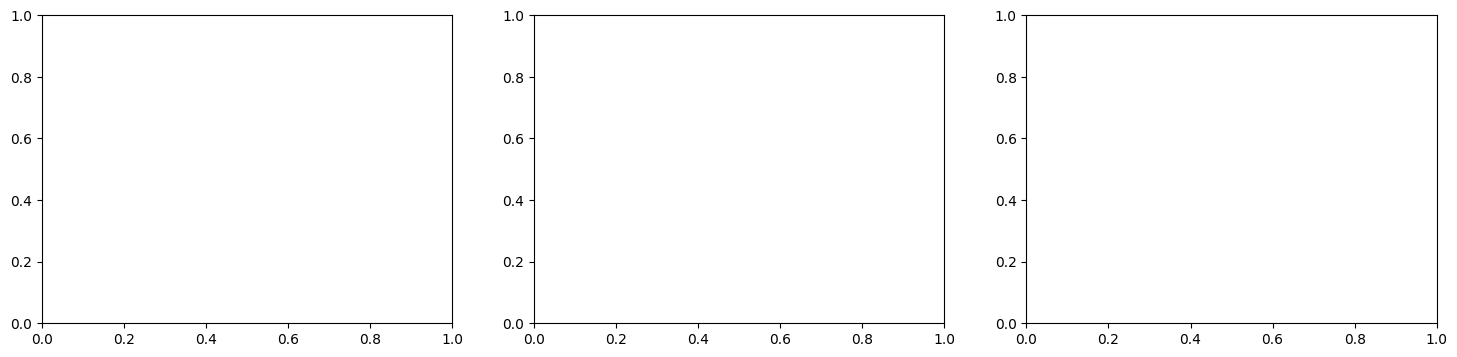

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_ylabel('Categorical Cross Entropy Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='best')

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='best')

axs[2].plot(history.history['auc'], label='Train AUC')
axs[2].plot(history.history['val_auc'], label='Validation AUC')
axs[2].set_ylabel('AUC Score')
axs[2].set_xlabel('Epoch')
axs[2].legend(loc='best')

plt.show()